In [1]:
# Standard library imports
import os
import json
import pandas as pd
import timm
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai.callback.core import Callback
import torch
import cv2
import numpy as np

In [2]:
# List all available models in timm
available_models = timm.list_models()

# Print each model in a more readable format
print("Available models in timm:")
for model in available_models:
    print(model)

Available models in timm:
bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw2_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_2_rw_384
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convformer_b36
convformer_m36
convformer_s18
convf

In [3]:
import os
import pandas as pd

# Define the path to your CSV file and training images
csv_path = os.path.join('COMP90086_2024_Project_train', 'train.csv')
train_dir = os.path.join('COMP90086_2024_Project_train', 'train')

# Read the CSV file into a DataFrame
train_data = pd.read_csv(csv_path)

# Add a column with the complete image path
train_data['image_path'] = train_data['id'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg"))

# Ensure that the 'stable_height' column is treated as a string for classification
train_data['stable_height'] = train_data['stable_height'].astype(str)

In [4]:
"""
goal: to have 65+ accuracy and good visiualisations for report
maybe try 2 techniques /shrug



VisionTransformerTrainer / model
    model name
    self.lr = None
    self.metrics = {}
    self.dls = dls
    
dataload - todo Jule
    split into training and validation
    data loader build
        inceptionv4 uses 299 299

testcase
    - VisionTransformerTrainer /model
    - dataloader



        
 https://docs.fast.ai/tutorial.vision.html   

need
    data
        model name
        model class
        Learning rate
        metrics
            Error rate
            epoc
            training loss
            validation loss
            accuracy
    functions
        auto learning rate Jack
        save results in dataframe for easy loading Jack
        post trained model weight Jule
            save model every 5 epoc
        auto test with different techniques
            data augmentation
            active learning????
            Progressive Training (cross that bridge when we get to it)
                number of bricks can i train them on both?
                stability can i train them on both?
                stabel height
            
        load visiualisaion from json data

"""

'\ngoal: to have 65+ accuracy and good visiualisations for report\nmaybe try 2 techniques /shrug\n\n\n\nVisionTransformerTrainer / model\n    model name\n    self.lr = None\n    self.metrics = {}\n    self.dls = dls\n    \ndataload - todo Jule\n    split into training and validation\n    data loader build\n        inceptionv4 uses 299 299\n\ntestcase\n    - VisionTransformerTrainer /model\n    - dataloader\n\n\n\n        \n https://docs.fast.ai/tutorial.vision.html   \n\nneed\n    data\n        model name\n        model class\n        Learning rate\n        metrics\n            Error rate\n            epoc\n            training loss\n            validation loss\n            accuracy\n    functions\n        auto learning rate Jack\n        save results in dataframe for easy loading Jack\n        post trained model weight Jule\n            save model every 5 epoc\n        auto test with different techniques\n            data augmentation\n            active learning????\n            Prog

In [5]:
# # Class to implement our own transformations for item_tfms
# class SimpleBlur(Transform):
#     def __init__(self, kernelSize=(5, 5)):
#         self.kernelSize = kernelSize

#     def encodes(self, img: PILImage):
#         # Convert the image to a NumPy array for OpenCV processing
#         img_np = np.array(img)
#         # Apply simple blur using the specified kernel size
#         blurred_img = cv2.blur(img_np, self.kernelSize)
#         # Convert the blurred image back to a PIL Image
#         return PILImage.create(blurred_img)

In [6]:
class VisionTransformerDataLoader:
    def __init__(self, train_data, item_tfms=None, batch_tfms=aug_transforms(), bs=8, valid_pct=0.2, num_workers=0):
        """
        Initialize the VisionTransformerDataLoader class.

        Args:
        - train_data: The training dataset.
        - item_tfms: Item-level transformations to apply (e.g., Resize, SimpleBlur).
        - batch_tfms: Batch-level transformations to apply (default is aug_transforms()).
        - bs: Batch size (default is 8).
        - valid_pct: Percentage of data to use for validation (default is 0.2).
        - num_workers: Number of workers for data loading (default is 0).
        """
        self.train_data = train_data
        self.item_tfms = item_tfms
        self.batch_tfms = batch_tfms
        self.bs = bs
        self.valid_pct = valid_pct
        self.num_workers = num_workers
    
    def get_dataloader(self):
        """
        Build and return the DataLoader.
        """
        # Define the DataBlock
        transformer_db = DataBlock(
            blocks=(ImageBlock, CategoryBlock),  # Input: Images, Output: Categories
            get_x=ColReader('image_path'),       # Read image paths
            get_y=ColReader('stable_height'),    # Read target labels
            splitter=RandomSplitter(valid_pct=self.valid_pct),  # Split training/validation sets
            item_tfms=self.item_tfms,            # Apply item-level transforms (e.g., resize, blur)
            batch_tfms=self.batch_tfms           # Apply batch-level transforms (e.g., augmentation)
        )

        # Create DataLoader from the DataBlock
        transformer_dl = transformer_db.dataloaders(self.train_data, bs=self.bs, num_workers=self.num_workers)

        return transformer_dl

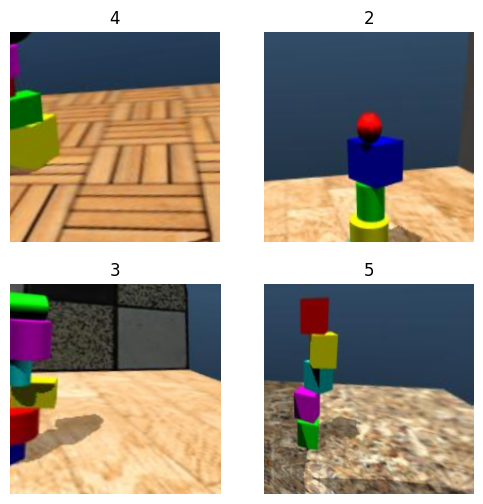

In [7]:
# Example usage of the class
item_tfms = [Resize(224), RandomResizedCrop(224)]  # Define your item-level transforms

# Initialize the DataLoader class
dataloader = VisionTransformerDataLoader(train_data, item_tfms=item_tfms, bs=8)

# Get the DataLoader
transformer_dl = dataloader.get_dataloader()

# Show a batch of images
transformer_dl.show_batch(max_n=4, figsize=(6, 6))

In [8]:
class SaveEvery5EpochsCallback(Callback):
    def __init__(self, model_name, transform_name):
        self.model_name = model_name
        self.transform_name = transform_name
    
    def after_epoch(self):
        if (self.epoch + 1) % 5 == 0:
            filename = f"{self.model_name}_{self.transform_name}_epoch_{self.epoch + 1}"
            self.learn.save(filename)
            print(f"Model saved at epoch {self.epoch + 1} as {filename}")

    def after_train(self):
        filename = f"{self.model_name}_{self.transform_name}_final"
        self.learn.save(filename)
        print(f"Model saved at the end of training as {filename}")

In [9]:
from typing import Tuple

class VisionTransformerTrainer:
    def __init__(self, model_name='vit_base_patch16_224', transform_name='basic', dls=None):
        self.model_name = model_name
        self.transform_name = transform_name
        self.learn = None
        self.lr = None
        self.metrics = {}
        self.dls = dls

        if self.dls is None:
            raise Exception("No dataloader provided. Please provide a dataloader when initializing the class.")
        else:
            print("Using provided dataloader.")

    def initialize_model(self, pretrained=True):
        self.model = timm.create_model(self.model_name, pretrained=pretrained, num_classes=self.dls.c)
        self.learn = vision_learner(self.dls, self.model_name, metrics=accuracy, pretrained=pretrained, cbs=CSVLogger())

        if torch.cuda.is_available():
            self.learn.model = self.learn.model.cuda()
            print("CUDA is available. Using GPU for training.")
        else:
            print("CUDA is not available. Using CPU for training.")

    def set_learning_rate(self):
        def find_optimal_lr(learner) -> float:
            lr_learn = learner.lr_find(suggest_funcs=(minimum, steep))
            lr_min, lr_steep = lr_learn
            return lr_steep
        self.lr = find_optimal_lr(self.learn)
        print(f"Learning rate set to: {self.lr}")

    def fine_tune(self, epochs=5):
        if self.learn is None:
            raise Exception("Model has not been initialized. Please run initialize_model() first.")
        if self.lr is None:
            raise Exception("Learning rate not set. Please set it using set_learning_rate() first.")

        # Save every 5 epochs with the combination of model and transformation name
        self.learn.add_cb(SaveEvery5EpochsCallback(self.model_name.replace('/', '_'), self.transform_name))
        self.learn.fine_tune(epochs, base_lr=self.lr)
        torch.cuda.empty_cache()

    def save_metrics(self):
        df = self.get_training_metrics()
        df['model_name'] = self.model_name
        df['transform_name'] = self.transform_name
        df['learning_rate'] = self.lr  # Add the learning rate to the DataFrame

        final_accuracy = self.final_accuracy
        final_epoch = self.final_epoch
        total_time = pd.to_timedelta(df['time'].apply(lambda x: f'00:{x}')).sum()

        # Include learning rate in the filename as well
        file_name = f"acc{final_accuracy:.3f}_epo{final_epoch:02d}_lr{self.lr:.1e}_tim{total_time.total_seconds():.0f}s_{self.model_name}_{self.transform_name}.csv"
        file_path = os.path.join('metrics', file_name)

        # Ensure the metrics folder exists
        os.makedirs('metrics', exist_ok=True)

        # Save the metrics DataFrame to CSV
        df.to_csv(file_path, index=False)
        print(f"Metrics saved to {file_path}")

    def get_training_metrics(self) -> pd.DataFrame:
        df = self.learn.csv_logger.read_log()
        self.training_metrics = df
        self.final_accuracy = df['accuracy'].iloc[-1]
        self.final_epoch = df['epoch'].iloc[-1]
        return df

    def plot_metrics(self):
        pass


In [10]:
"""
potential models to test
'efficientnet_b0'
mobilenetv4_conv_medium
mobilenetv4_hybrid_medium
Vanilla ViT, BEiT, DeiT, Resnet34, Resnet50, inceptionV4, inceptionV3

"""

"\npotential models to test\n'efficientnet_b0'\nmobilenetv4_conv_medium\nmobilenetv4_hybrid_medium\nVanilla ViT, BEiT, DeiT, Resnet34, Resnet50, inceptionV4, inceptionV3\n\n"

In [ ]:
# Define item-level transformations
item_transforms = {
    'none': None,  # No item transformations
    'zoom': Zoom(),  # Apply zoom transform
    'flip': FlipItem(p=0.5),  # Flip with 50% probability
    'grayscale': IntToFloatTensor(),  # Grayscale conversion
    'random_resized_crop': RandomResizedCrop(224, min_scale=0.5),
    'contrast': Contrast(max_lighting=0.4, p=0.75),  # Should be moved to batch-level
    'saturation': Saturation(max_lighting=0.4, p=0.75),  # Should be moved to batch-level
}

# Define batch-level augmentations (if any, or use None to skip)
augmentations = {
    'basic': aug_transforms(),
}

# List of models to test
model_names = [
    # 'efficientnet_b0',
    # 'mobilenetv3_large_100', 
    # 'mobilenetv3_rw',
    # 'vit_base_patch16_224', 
    # 'beit_base_patch16_224', 
    # 'deit_base_patch16_224', #did not run this at all
    'resnet34', 
    'resnet50', 
    'inception_v3', 
    'inception_v4'
]

# Loop through each Vision Transformer model, item_tfms, and augmentations
for model_name in model_names:
    for item_tfms_name, item_tfms in item_transforms.items():
        for augment_name, batch_tfms in augmentations.items():
            transform_name = f"{item_tfms_name}_{augment_name}"  # Combine item and batch transform names
            print(f"\nTraining with model: {model_name}, item_tfms: {item_tfms_name}, and augmentation: {augment_name}")

            try:
                # Create a new DataLoader with the current item and batch transforms
                transformer_dl = VisionTransformerDataLoader(
                    train_data=train_data, 
                    item_tfms=item_tfms,    # Pass the item-level transforms here
                    batch_tfms=batch_tfms   # Pass the batch-level augmentations here
                ).get_dataloader()

                # Initialize the Vision Transformer Trainer for the current model and augmentation
                trainer = VisionTransformerTrainer(
                    model_name=model_name, 
                    transform_name=transform_name,  # Combine item and batch tfms names
                    dls=transformer_dl
                )

                # Initialize the model
                trainer.initialize_model(pretrained=True)

                # Set the learning rate automatically
                trainer.set_learning_rate()

                # Fine-tune the model
                trainer.fine_tune(epochs=5)  # Adjust the number of epochs as needed

                # Save the training metrics
                trainer.save_metrics()


            except Exception as e:
                print(f"An error occurred while training model {model_name} with item_tfms {item_tfms_name} and augmentation {augment_name}: {e}")


Training with model: resnet34, item_tfms: none, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 9.12010818865383e-07


epoch,train_loss,valid_loss,accuracy,time
0,3.005985,2.357862,0.160156,01:55


Model saved at the end of training as resnet34_none_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,3.125834,2.332969,0.164062,01:02
1,3.125572,2.314145,0.166016,00:53
2,2.931194,2.304018,0.167318,01:07
3,3.019146,2.285606,0.164062,01:35
4,3.035413,2.352234,0.167969,01:42


Model saved at the end of training as resnet34_none_basic_final
Model saved at the end of training as resnet34_none_basic_final
Model saved at the end of training as resnet34_none_basic_final
Model saved at the end of training as resnet34_none_basic_final
Model saved at the end of training as resnet34_none_basic_final
Model saved at epoch 5 as resnet34_none_basic_epoch_5
Metrics saved to metrics\acc0.168_epo04_lr9.1e-07_tim379s_resnet34_none_basic.csv

Training with model: resnet34, item_tfms: zoom, and augmentation: basic
Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:
An error occurred while training model resnet34 with item_tfms zoom and augmentation basic: "check_uniform_bounds" not implemented for 'Byte'

Training with model: resnet34, item_tfms: flip, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 1.5848931980144698e-06


epoch,train_loss,valid_loss,accuracy,time
0,3.179509,2.418587,0.169922,01:29


Model saved at the end of training as resnet34_flip_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,2.994327,2.385444,0.175781,02:08
1,3.111900,2.361670,0.176432,01:36
2,3.059946,2.377513,0.177083,01:27
3,2.980305,2.373005,0.163411,01:25
4,3.101286,2.420463,0.166667,01:26


Model saved at the end of training as resnet34_flip_basic_final
Model saved at the end of training as resnet34_flip_basic_final
Model saved at the end of training as resnet34_flip_basic_final
Model saved at the end of training as resnet34_flip_basic_final
Model saved at the end of training as resnet34_flip_basic_final
Model saved at epoch 5 as resnet34_flip_basic_epoch_5
Metrics saved to metrics\acc0.167_epo04_lr1.6e-06_tim482s_resnet34_flip_basic.csv

Training with model: resnet34, item_tfms: grayscale, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 1.0964781722577754e-06


epoch,train_loss,valid_loss,accuracy,time
0,3.031758,2.431890,0.164062,01:09


Model saved at the end of training as resnet34_grayscale_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,3.080381,2.377340,0.166016,01:26
1,3.076469,2.342572,0.168620,01:23
2,3.122649,2.367771,0.173828,01:26
3,3.167785,2.331457,0.170573,01:29
4,3.081859,2.373026,0.149740,01:30


Model saved at the end of training as resnet34_grayscale_basic_final
Model saved at the end of training as resnet34_grayscale_basic_final
Model saved at the end of training as resnet34_grayscale_basic_final
Model saved at the end of training as resnet34_grayscale_basic_final
Model saved at the end of training as resnet34_grayscale_basic_final
Model saved at epoch 5 as resnet34_grayscale_basic_epoch_5
Metrics saved to metrics\acc0.150_epo04_lr1.1e-06_tim434s_resnet34_grayscale_basic.csv

Training with model: resnet34, item_tfms: random_resized_crop, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 2.75422871709452e-06


epoch,train_loss,valid_loss,accuracy,time
0,3.074374,2.317321,0.178385,01:10


Model saved at the end of training as resnet34_random_resized_crop_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,3.006364,2.357278,0.173177,01:29
1,3.017715,2.345553,0.177734,01:30
2,3.030687,2.323021,0.179688,01:32
3,3.004660,2.324584,0.170573,01:31
4,2.967731,2.317048,0.181641,01:33


Model saved at the end of training as resnet34_random_resized_crop_basic_final
Model saved at the end of training as resnet34_random_resized_crop_basic_final
Model saved at the end of training as resnet34_random_resized_crop_basic_final
Model saved at the end of training as resnet34_random_resized_crop_basic_final
Model saved at the end of training as resnet34_random_resized_crop_basic_final
Model saved at epoch 5 as resnet34_random_resized_crop_basic_epoch_5
Metrics saved to metrics\acc0.182_epo04_lr2.8e-06_tim455s_resnet34_random_resized_crop_basic.csv

Training with model: resnet34, item_tfms: contrast, and augmentation: basic
Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:
An error occurred while training model resnet34 with item_tfms contrast and augmentation basic: "check_uniform_bounds" not implemented for 'Byte'

Training with model: resnet34, item_tfms: saturation, and augmentation: basic
Could not do one pass in your

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\julev\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CUDA is available. Using GPU for training.


Learning rate set to: 1.2022644114040304e-05


epoch,train_loss,valid_loss,accuracy,time
0,2.882657,6.770483,0.186849,01:29


Model saved at the end of training as resnet50_none_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,2.954593,2.382053,0.188802,01:56
1,2.926283,2.172603,0.192708,01:53
2,2.846025,2.142255,0.207031,01:52
3,2.871483,2.162717,0.201172,01:52
4,2.818407,2.184095,0.204427,01:52


Model saved at the end of training as resnet50_none_basic_final
Model saved at the end of training as resnet50_none_basic_final
Model saved at the end of training as resnet50_none_basic_final
Model saved at the end of training as resnet50_none_basic_final
Model saved at the end of training as resnet50_none_basic_final
Model saved at epoch 5 as resnet50_none_basic_epoch_5
Metrics saved to metrics\acc0.204_epo04_lr1.2e-05_tim565s_resnet50_none_basic.csv

Training with model: resnet50, item_tfms: zoom, and augmentation: basic
Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:
An error occurred while training model resnet50 with item_tfms zoom and augmentation basic: "check_uniform_bounds" not implemented for 'Byte'

Training with model: resnet50, item_tfms: flip, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 4.786300905834651e-06


epoch,train_loss,valid_loss,accuracy,time
0,2.903075,2.505680,0.171224,01:25


Model saved at the end of training as resnet50_flip_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,3.121630,2.427006,0.177083,01:50
1,2.951076,2.311886,0.156901,01:50
2,2.903598,2.214102,0.180990,01:54
3,2.959943,3.626546,0.171224,01:58
4,3.028352,2.368297,0.165365,01:53


Model saved at the end of training as resnet50_flip_basic_final
Model saved at the end of training as resnet50_flip_basic_final
Model saved at the end of training as resnet50_flip_basic_final
Model saved at the end of training as resnet50_flip_basic_final
Model saved at the end of training as resnet50_flip_basic_final
Model saved at epoch 5 as resnet50_flip_basic_epoch_5
Metrics saved to metrics\acc0.165_epo04_lr4.8e-06_tim565s_resnet50_flip_basic.csv

Training with model: resnet50, item_tfms: grayscale, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 2.75422871709452e-06


epoch,train_loss,valid_loss,accuracy,time
0,2.929726,2.271314,0.175781,01:35


Model saved at the end of training as resnet50_grayscale_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,2.919429,2.288189,0.175130,01:53
1,3.048938,2.248892,0.185547,01:52
2,2.983525,2.248015,0.180990,01:52
3,2.971173,2.254605,0.182943,01:53
4,2.859056,2.302463,0.173177,01:56


Model saved at the end of training as resnet50_grayscale_basic_final
Model saved at the end of training as resnet50_grayscale_basic_final
Model saved at the end of training as resnet50_grayscale_basic_final
Model saved at the end of training as resnet50_grayscale_basic_final
Model saved at the end of training as resnet50_grayscale_basic_final
Model saved at epoch 5 as resnet50_grayscale_basic_epoch_5
Metrics saved to metrics\acc0.173_epo04_lr2.8e-06_tim566s_resnet50_grayscale_basic.csv

Training with model: resnet50, item_tfms: random_resized_crop, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 3.981071586167673e-06


epoch,train_loss,valid_loss,accuracy,time
0,2.940698,2.305990,0.177083,01:38


Model saved at the end of training as resnet50_random_resized_crop_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,3.017955,5.849716,0.186198,02:08
1,2.991878,2.415536,0.170573,02:05
2,2.995369,2.298913,0.185547,02:05
3,3.015457,2.595345,0.181641,02:04
4,3.005282,2.557122,0.180339,02:04


Model saved at the end of training as resnet50_random_resized_crop_basic_final
Model saved at the end of training as resnet50_random_resized_crop_basic_final
Model saved at the end of training as resnet50_random_resized_crop_basic_final
Model saved at the end of training as resnet50_random_resized_crop_basic_final
Model saved at the end of training as resnet50_random_resized_crop_basic_final
Model saved at epoch 5 as resnet50_random_resized_crop_basic_epoch_5
Metrics saved to metrics\acc0.180_epo04_lr4.0e-06_tim626s_resnet50_random_resized_crop_basic.csv

Training with model: resnet50, item_tfms: contrast, and augmentation: basic
Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:
An error occurred while training model resnet50 with item_tfms contrast and augmentation basic: "check_uniform_bounds" not implemented for 'Byte'

Training with model: resnet50, item_tfms: saturation, and augmentation: basic
Could not do one pass in your

model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\julev\.cache\huggingface\hub\models--timm--inception_v3.tv_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CUDA is available. Using GPU for training.


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Learning rate set to: 8.31763736641733e-06


epoch,train_loss,valid_loss,accuracy,time
0,3.068688,2.442939,0.162109,01:33


Model saved at the end of training as inception_v3_none_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,2.971731,2.393181,0.169922,02:02
1,2.865402,2.422263,0.158203,01:59
2,2.995638,2.346291,0.184896,02:02
3,2.771230,2.346371,0.186198,02:00
4,2.900620,2.328555,0.176432,02:02


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Model saved at the end of training as inception_v3_none_basic_final
Model saved at the end of training as inception_v3_none_basic_final
Model saved at the end of training as inception_v3_none_basic_final
Model saved at the end of training as inception_v3_none_basic_final
Model saved at the end of training as inception_v3_none_basic_final
Model saved at epoch 5 as inception_v3_none_basic_epoch_5
Metrics saved to metrics\acc0.176_epo04_lr8.3e-06_tim605s_inception_v3_none_basic.csv

Training with model: inception_v3, item_tfms: zoom, and augmentation: basic
Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:
An error occurred while training model inception_v3 with item_tfms zoom and augmentation basic: "check_uniform_bounds" not implemented for 'Byte'

Training with model: inception_v3, item_tfms: flip, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 2.2908675418875646e-06


epoch,train_loss,valid_loss,accuracy,time
0,3.070663,2.492112,0.155599,01:34


Model saved at the end of training as inception_v3_flip_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,3.149894,2.518038,0.166016,02:02
1,3.070384,2.471854,0.162109,02:01
2,3.138023,2.417333,0.182943,02:03
3,3.022446,2.418982,0.175781,02:00
4,3.060930,2.415438,0.185547,02:15


Model saved at the end of training as inception_v3_flip_basic_final
Model saved at the end of training as inception_v3_flip_basic_final
Model saved at the end of training as inception_v3_flip_basic_final
Model saved at the end of training as inception_v3_flip_basic_final
Model saved at the end of training as inception_v3_flip_basic_final
Model saved at epoch 5 as inception_v3_flip_basic_epoch_5
Metrics saved to metrics\acc0.186_epo04_lr2.3e-06_tim621s_inception_v3_flip_basic.csv

Training with model: inception_v3, item_tfms: grayscale, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 2.75422871709452e-06


epoch,train_loss,valid_loss,accuracy,time
0,3.088326,2.535153,0.146484,01:38


Model saved at the end of training as inception_v3_grayscale_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,2.967321,2.496385,0.147786,02:01
1,3.059904,2.473791,0.153646,02:08
2,3.130635,2.424659,0.154948,02:00
3,2.923835,2.444725,0.149740,02:06
4,3.023469,2.356941,0.167969,02:07


Model saved at the end of training as inception_v3_grayscale_basic_final
Model saved at the end of training as inception_v3_grayscale_basic_final
Model saved at the end of training as inception_v3_grayscale_basic_final
Model saved at the end of training as inception_v3_grayscale_basic_final
Model saved at the end of training as inception_v3_grayscale_basic_final
Model saved at epoch 5 as inception_v3_grayscale_basic_epoch_5
Metrics saved to metrics\acc0.168_epo04_lr2.8e-06_tim622s_inception_v3_grayscale_basic.csv

Training with model: inception_v3, item_tfms: random_resized_crop, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 1.4454397387453355e-05


epoch,train_loss,valid_loss,accuracy,time
0,2.831747,2.480375,0.169271,01:37


Model saved at the end of training as inception_v3_random_resized_crop_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,2.829241,2.345021,0.177734,02:03
1,2.799628,2.298400,0.184245,02:08
2,2.762734,2.219320,0.203125,02:06
3,2.764753,2.234720,0.207682,02:06
4,2.675315,2.243636,0.194010,02:03


Model saved at the end of training as inception_v3_random_resized_crop_basic_final
Model saved at the end of training as inception_v3_random_resized_crop_basic_final
Model saved at the end of training as inception_v3_random_resized_crop_basic_final
Model saved at the end of training as inception_v3_random_resized_crop_basic_final
Model saved at the end of training as inception_v3_random_resized_crop_basic_final
Model saved at epoch 5 as inception_v3_random_resized_crop_basic_epoch_5
Metrics saved to metrics\acc0.194_epo04_lr1.4e-05_tim626s_inception_v3_random_resized_crop_basic.csv

Training with model: inception_v3, item_tfms: contrast, and augmentation: basic
Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:
An error occurred while training model inception_v3 with item_tfms contrast and augmentation basic: "check_uniform_bounds" not implemented for 'Byte'

Training with model: inception_v3, item_tfms: saturation, and augmentat

model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\julev\.cache\huggingface\hub\models--timm--inception_v4.tf_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CUDA is available. Using GPU for training.


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Learning rate set to: 1.3182567499825382e-06


epoch,train_loss,valid_loss,accuracy,time
0,3.067061,6.239272,0.170573,02:18


Model saved at the end of training as inception_v4_none_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,2.977468,7.408507,0.182943,03:19
1,3.079154,3.313004,0.154948,03:31
2,2.974993,21.096388,0.173177,03:35
3,3.053052,18.212242,0.166667,03:11
4,3.060128,8.944594,0.159505,03:06


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Model saved at the end of training as inception_v4_none_basic_final
Model saved at the end of training as inception_v4_none_basic_final
Model saved at the end of training as inception_v4_none_basic_final
Model saved at the end of training as inception_v4_none_basic_final
Model saved at the end of training as inception_v4_none_basic_final
Model saved at epoch 5 as inception_v4_none_basic_epoch_5
Metrics saved to metrics\acc0.160_epo04_lr1.3e-06_tim1002s_inception_v4_none_basic.csv

Training with model: inception_v4, item_tfms: zoom, and augmentation: basic
Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:
An error occurred while training model inception_v4 with item_tfms zoom and augmentation basic: "check_uniform_bounds" not implemented for 'Byte'

Training with model: inception_v4, item_tfms: flip, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 6.309573450380412e-07


epoch,train_loss,valid_loss,accuracy,time
0,3.058009,56.532207,0.166016,02:12


Model saved at the end of training as inception_v4_flip_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,3.083936,14.782071,0.171224,03:03
1,3.164979,28.082037,0.165365,03:03
2,3.035907,12.653499,0.167318,02:23
3,3.023580,17.318899,0.179688,02:14
4,2.957718,38.130180,0.192708,02:09


Model saved at the end of training as inception_v4_flip_basic_final
Model saved at the end of training as inception_v4_flip_basic_final
Model saved at the end of training as inception_v4_flip_basic_final
Model saved at the end of training as inception_v4_flip_basic_final
Model saved at the end of training as inception_v4_flip_basic_final
Model saved at epoch 5 as inception_v4_flip_basic_epoch_5
Metrics saved to metrics\acc0.193_epo04_lr6.3e-07_tim772s_inception_v4_flip_basic.csv

Training with model: inception_v4, item_tfms: grayscale, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 9.12010818865383e-07


epoch,train_loss,valid_loss,accuracy,time
0,2.965761,17.918028,0.180339,01:49


Model saved at the end of training as inception_v4_grayscale_basic_final


epoch,train_loss,valid_loss,accuracy,time
0,3.054655,5.570028,0.173828,02:11
1,2.932779,14.111159,0.174479,02:11
2,2.958616,8.656373,0.175781,02:07
3,3.007666,20.735619,0.184245,02:35
4,2.987395,30.392115,0.177734,02:58


Model saved at the end of training as inception_v4_grayscale_basic_final
Model saved at the end of training as inception_v4_grayscale_basic_final
Model saved at the end of training as inception_v4_grayscale_basic_final
Model saved at the end of training as inception_v4_grayscale_basic_final
Model saved at the end of training as inception_v4_grayscale_basic_final
Model saved at epoch 5 as inception_v4_grayscale_basic_epoch_5
Metrics saved to metrics\acc0.178_epo04_lr9.1e-07_tim722s_inception_v4_grayscale_basic.csv

Training with model: inception_v4, item_tfms: random_resized_crop, and augmentation: basic
Using provided dataloader.
CUDA is available. Using GPU for training.


Learning rate set to: 2.75422871709452e-06


epoch,train_loss,valid_loss,accuracy,time
